In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from fastai.vision.all import *

In [2]:
set_seed(999, reproducible=True)
BATCH_SIZE = 32
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,../input/petfinder-pawpularity-score/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,../input/petfinder-pawpularity-score/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,../input/petfinder-pawpularity-score/train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,../input/petfinder-pawpularity-score/train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,../input/petfinder-pawpularity-score/train/7b77e1a6d93667b575d57db83facd860.jpg


In [4]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.591990105774553
There are 100 unique values of Pawpularity score


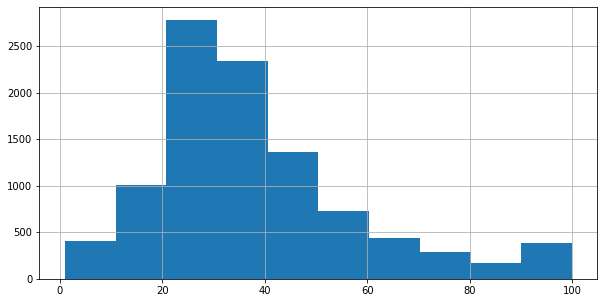

In [5]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

In [6]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [7]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

960 960


In [8]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [9]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [10]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

<AxesSubplot:>

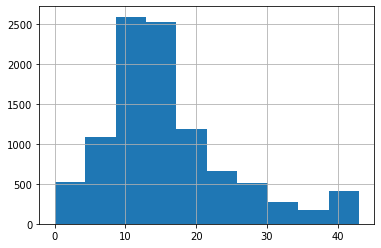

In [11]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

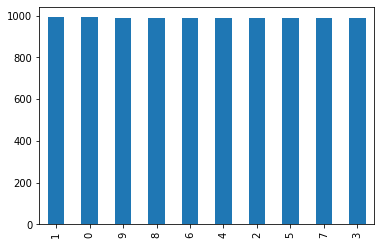

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')


In [13]:
train_df[train_df['fold']==0].head()
train_df[train_df['fold']==0]['bins'].value_counts()
train_df[train_df['fold']==1]['bins'].value_counts()

11    94
15    70
12    62
13    60
10    54
9     49
14    48
7     42
20    38
17    37
16    36
8     36
18    34
43    30
19    26
23    25
21    21
27    18
0     17
22    16
6     16
5     15
4     15
25    12
24    12
26    11
31    11
28    10
3      7
1      7
29     7
33     6
2      6
30     6
35     6
34     5
32     5
40     4
38     4
36     4
37     3
41     3
39     2
42     2
Name: bins, dtype: int64

In [14]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [15]:
def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls


In [16]:
#Valid Kfolder size
the_data = get_data(0)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [17]:
def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [18]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


SuggestedLRs(valley=0.00011673145490931347)

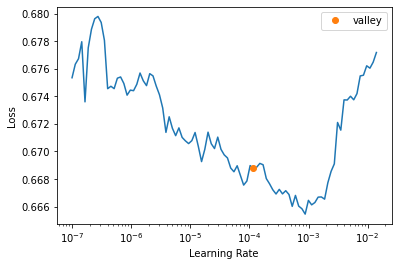

In [19]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100
get_learner(fold_num=0).lr_find(end_lr=3e-2)

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649252,0.648630,18.492990,07:03
1,0.642295,0.642434,17.639019,07:04
2,0.636745,0.641628,17.562702,07:04
3,0.631284,0.641890,17.575989,07:04
4,0.628943,0.642106,17.580494,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6486299633979797.
Better model found at epoch 1 with valid_loss value: 0.6424338221549988.
Better model found at epoch 2 with valid_loss value: 0.6416275501251221.
No improvement since epoch 2: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647404,0.642736,17.634117,07:02
1,0.643846,0.640681,17.336287,07:03
2,0.637714,0.638719,17.155169,07:02
3,0.630138,0.638246,17.053953,07:02
4,0.628876,0.638147,17.041834,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6427363753318787.
Better model found at epoch 1 with valid_loss value: 0.640680730342865.
Better model found at epoch 2 with valid_loss value: 0.6387185454368591.
Better model found at epoch 3 with valid_loss value: 0.6382455229759216.
Better model found at epoch 4 with valid_loss value: 0.6381466388702393.


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648946,0.646069,18.063717,07:02
1,0.641929,0.643915,17.773884,07:03
2,0.635003,0.643910,17.739141,07:03
3,0.632639,0.643806,17.740097,07:04
4,0.624051,0.644824,17.854523,07:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.646068811416626.
Better model found at epoch 1 with valid_loss value: 0.6439154148101807.
Better model found at epoch 2 with valid_loss value: 0.6439104080200195.
Better model found at epoch 3 with valid_loss value: 0.6438058018684387.
No improvement since epoch 2: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649754,0.643171,17.646770,07:04
1,0.643062,0.639264,17.108551,07:03
2,0.636641,0.638862,17.056330,07:04
3,0.628931,0.637615,16.890516,07:04
4,0.627916,0.637426,16.854588,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6431706547737122.
Better model found at epoch 1 with valid_loss value: 0.6392641663551331.
Better model found at epoch 2 with valid_loss value: 0.6388623714447021.
Better model found at epoch 3 with valid_loss value: 0.6376151442527771.
Better model found at epoch 4 with valid_loss value: 0.6374263167381287.


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648842,0.646305,18.158276,07:02
1,0.641842,0.645048,18.041422,07:03
2,0.637438,0.645322,18.058014,07:02
3,0.631561,0.643480,17.767477,07:04
4,0.627101,0.643693,17.777769,07:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.646304726600647.
Better model found at epoch 1 with valid_loss value: 0.645047664642334.
Better model found at epoch 3 with valid_loss value: 0.6434800624847412.


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648479,0.643347,17.890982,07:04
1,0.639383,0.640257,17.416405,07:03
2,0.638186,0.637075,17.000574,07:03
3,0.630302,0.637536,17.052551,07:05
4,0.627031,0.637309,16.995905,07:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6433469653129578.
Better model found at epoch 1 with valid_loss value: 0.6402572393417358.
Better model found at epoch 2 with valid_loss value: 0.6370749473571777.


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647728,0.648324,18.409306,07:04
1,0.638573,0.644945,18.019636,07:04
2,0.637786,0.642501,17.680603,07:03
3,0.633920,0.642156,17.599657,07:02
4,0.627388,0.642504,17.624203,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6483243703842163.
Better model found at epoch 1 with valid_loss value: 0.6449449062347412.
Better model found at epoch 2 with valid_loss value: 0.6425011157989502.
Better model found at epoch 3 with valid_loss value: 0.6421555876731873.


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649828,0.647506,18.132938,07:02
1,0.641939,0.644097,17.705326,07:04
2,0.634038,0.643664,17.724339,07:03
3,0.630162,0.644548,17.842587,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6475061774253845.
Better model found at epoch 1 with valid_loss value: 0.6440970301628113.
Better model found at epoch 2 with valid_loss value: 0.6436643004417419.
No improvement since epoch 1: early stopping


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648897,0.644341,17.908651,07:03
1,0.641219,0.639839,17.303482,07:04
2,0.637452,0.640261,17.371517,07:03
3,0.630047,0.640023,17.293312,07:02
4,0.625533,0.639962,17.291037,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6443405151367188.
Better model found at epoch 1 with valid_loss value: 0.6398391127586365.


Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650217,0.642004,17.665598,07:03
1,0.645012,0.638420,17.169758,07:04
2,0.637419,0.636345,16.927261,07:04
3,0.632798,0.635881,16.825695,07:03
4,0.625897,0.636021,16.843723,07:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6420043110847473.
Better model found at epoch 1 with valid_loss value: 0.6384199857711792.
Better model found at epoch 2 with valid_loss value: 0.6363451480865479.
Better model found at epoch 3 with valid_loss value: 0.6358805298805237.


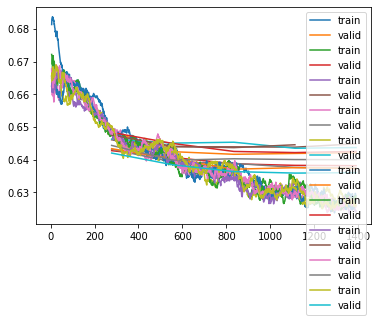

In [20]:
import gc

all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [21]:
np.mean(np.stack(all_preds*100))

0.37745056

In [22]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)